In [1]:
from sklearn.preprocessing import MinMaxScaler
from datasets import get_dateset
import matplotlib.pyplot as plt
from torch import nn, optim
import torch.nn.functional as F
from scipy.io import arff
import pandas as pd
import numpy as np
import pickle
import torch
from tqdm import tqdm
import os
import time
import torch.optim as optim
EEGTrain, EEGValidation, EEGTest = get_dateset('EEG')
EnergyTrain, EnergyValidation, EnergyTest = get_dateset('Energy')
scaler = MinMaxScaler(feature_range=(0,1))
!pip freeze > ../requirements.txt
device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
device = 'cpu'
torch.set_default_device(device)
torch.set_num_threads(4)

ImportError: cannot import name 'get_dateset' from 'datasets' (/Users/paulmagos/anaconda3/lib/python3.11/site-packages/datasets/__init__.py)

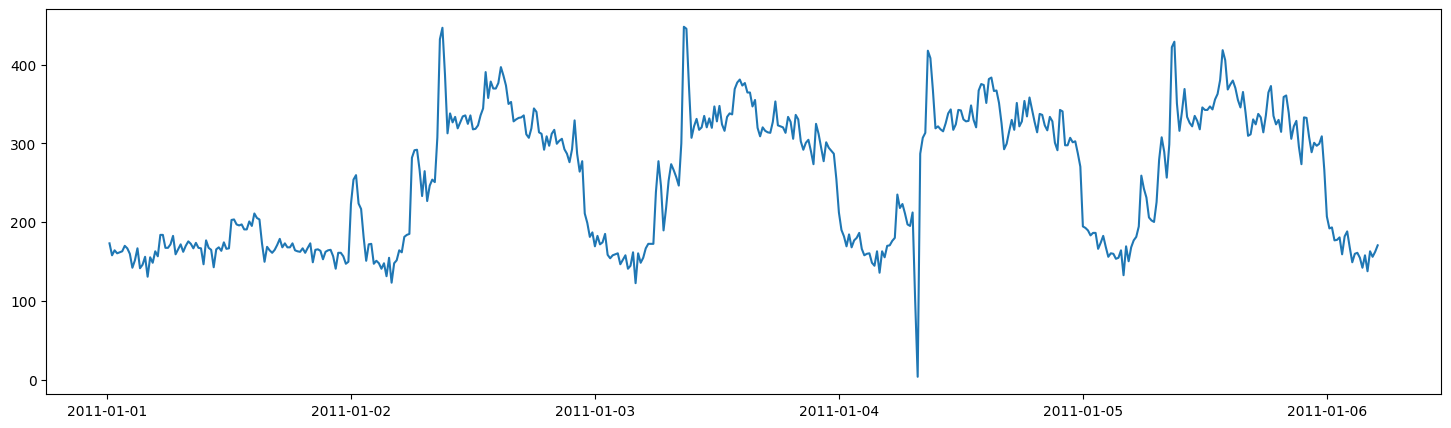

In [ ]:
plt.figure(figsize=(18, 5))
plt.plot(EnergyTrain['Date'][:500], EnergyTrain['MT_201'][:500])
plt.show()

In [ ]:
class GMM(nn.Module):
    def __init__(self, M=10, device = 'cpu', debug=False, **kwargs) -> None:
        super(GMM, self).__init__()
        self.M = M
        self.device = device
        self.debug = debug
    
    def __call__(self, X):
        D = X.shape[-1] // self.M - 2
        # Leave mu values as they are since they're unconstrained
        # Scale sigmas with exp, so all values are non-negative
        X[:, D*self.M:(D+1)*self.M] = torch.exp(X[:, D*self.M:(D+1)*self.M]).to(self.device)
        # Scale alphas with softmax, so all values are between [0,1] and sum up to 1
        X[:, (D+1)*self.M:(D+2)*self.M] = F.softmax(X[:, (D+1)*self.M:(D+2)*self.M], dim=1).to(self.device)
        if self.debug:
            print(X[0].shape)
        return X[0].to(self.device)
    
def gmm_loss(y_true, y_pred):
    """
    GMM loss function.
    Assumes that y_pred has (D+2)*M dimensions and y_true has D dimensions. The first 
    M*D features are treated as means, the next M features as standard devs and the last 
    M features as mixture components of the GMM. 
    """
    def loss(m, M, D, y_true, y_pred):
        mu = y_pred[D*m:(m+1)*D]
        sigma = y_pred[D*M+m]
        alpha = y_pred[(D+1)*M+m]
        return (alpha / sigma / torch.sqrt(2. * torch.tensor(np.pi))) * torch.exp(-torch.sum((mu - y_true)**2, -1) / (2*sigma**2))

    D = y_true.shape[-1]
    M = y_pred.shape[-1] // (D+2)
    result = torch.zeros(M, 1)
    for m in range(M):
        result[m] = loss(m, M, D, y_true, y_pred)
        
    return -torch.log(result.sum(0))

In [ ]:
class Net(nn.Module):
    def __init__(self, *args) -> None:
        super(Net, self).__init__()
        input_size, output_size, hidden_size, mixture_dim, dropout, num_layers, bidirectional, device, debug = args
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, dropout=dropout, num_layers=num_layers, device=device, bidirectional=bidirectional)
        self.dense = nn.Linear(in_features=hidden_size*(2 if bidirectional else 1), out_features=(output_size+2)*mixture_dim, device=device)
        self.gmm = GMM(M = mixture_dim, device = device, debug=debug)
        self.step = 0

    def forward(self, x):
        out = self.lstm(x)
        out = self.dense(out[0])
        out = self.gmm(out)
        self.step = self.step+1
        if self.step == len(x)-1:
            self.step = 0
        return out
        
        
train_data = scaler.fit_transform(np.array(EnergyTrain[EnergyTrain.columns[1:]]))
train_data = torch.Tensor(train_data)
validation_data = scaler.fit_transform(np.array(EnergyValidation[EnergyValidation.columns[1:]]))
validation_data = torch.Tensor(validation_data)

hidden_size = 100
input_size = train_data.shape[-1]
output_size = input_size
num_layers = 5
lr = 0.0001
bidirectional = True
mixture_dim = 10
num_time_steps = 50


args = (input_size, output_size, hidden_size, mixture_dim, 0.2, num_layers, bidirectional, device, False)
model = Net(*args)

criterion = gmm_loss
optimizer = optim.RMSprop(model.parameters(), lr=lr)


model

Net(
  (lstm): LSTM(370, 100, num_layers=5, dropout=0.2, bidirectional=True)
  (dense): Linear(in_features=200, out_features=3720, bias=True)
  (gmm): GMM()
)

In [ ]:
# Training loop
print("Starting training...")
for epoch in range(1, 100 + 1):
    print(f'Epoch {epoch}')
    losses_epoch = []
    for i in range(len(train_data) - 1):
        optimizer.zero_grad()
        outputs = model(train_data[i:i+1, :].to(device))
        loss = criterion(train_data[i+1, :].to(device), outputs)
        loss.backward()
        # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
        optimizer.step()
        losses_epoch.append(loss.item())
    mean_loss = np.mean(losses_epoch)
    print('- loss:', mean_loss)

Starting training...
Epoch 1
- loss: 3.3024118895433388
Epoch 2
- loss: 1.1988149613750225
Epoch 3
- loss: 1.0529845478583355
Epoch 4
- loss: 0.9617569470892147
Epoch 5
- loss: 0.8891411995401188
Epoch 6
- loss: 0.8468851617404393
Epoch 7
- loss: 0.8617079270129301
Epoch 8
- loss: 0.8674332037263986
Epoch 9
- loss: 0.8442268906807413
Epoch 10
- loss: 0.8480762060807676
Epoch 11
- loss: 0.8594680173056466
Epoch 12
- loss: 0.8226663908179925
Epoch 13


KeyboardInterrupt: 

In [ ]:
start = time.time()
losses_epoch = []
with tqdm(total=100) as p:
    for i in range(1, 101): 
        outputs = model(train_data[i:i+1, :].to(device))
        loss = criterion(train_data[i+1, :].to(device), outputs)
        losses_epoch.append(loss.item())
        p.update(1)
print(f'Took {time.time()-start} on {device}')
mean_loss = np.mean(losses_epoch)
print('- loss:', mean_loss)

: 

In [ ]:
# out = model.out[0].cpu().detach().numpy()
# print(scaler.inverse_transform(out.reshape(1,  -1)))

: 